# NBA Cold Maps

NBA shot charts are a popular way of visualizing shooting efficiency across different parts of the basketball court. Some examples include:

* [Region-based](http://i.cdn.turner.com/nba/nba/.element/media/2.0/teamsites/bucks/chart-giannis.png), which separate the court into sections based on angle and distance from the hoop.
* [Scatter plots](http://graphics.latimes.com/kobe-every-shot-ever/), which simply plot every single make and miss.
* [Kirk Goldsberry's / Grantland's hexagonal heat maps](http://grantland.com/the-triangle/courtvision-how-the-heat-and-spurs-score/), charts which visualize four dimensions (x location, y location, volume by hexagon size, and efficiency by hexagon color). 

One quirk of these charts is that "misses" are all treated alike; that is, a missed layup is viewed as the same as a missed three. But there is reason to believe this perspective is inappropriate! That is, perhaps a bricked three can lead to a fast break, whereas a missed layup can lead to a offensive putback. 

To answer this question with data, I decided to produce *cold maps*, which visualize the *next-possession value* from each part of the floor. That is, for each shot location, I compute the expected point outcome of the subsequent possession conditional on a missed shot (where a positive value represents a point for the shooting/missing team, and a negative value represents a point for the opposing/defending team).

![png](coldmap.png)

In the above figure, cooler colors represent "safer" shots (i.e., less punishing next-possession value), whereas warmer colors represent "more dangerous" shots (i.e., more negative next-possession value). The size of each cell represents the volume of misses from each court location.

## Other info

The relevant files are:

    gather.py
    draw.py

Prerequisite packages include:

    matplotlib
    numpy
    pandas
    requests
    
For any questions, bug reports, etc., contact [Steven S. Kim](http://ssk.im) via e-mail at [steven_kim@brown.edu](mailto:steven_kim@brown.edu).

## Main idea

At a high level, here are the steps to producing such a plot:

* Gather court location data for each missed shot.
* For each missed shot, go through play-by-play data to find the value of the next possession.
* Separate the court into hexagonal tiles and compute the miss volume and next-possession value within each tile.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

## Getting the data

We will retrieve game and player logs from [stats.nba.com](http://stats.nba.com), which has an extensive API for retrieving all manner of data.

All the code for pulling data can be found in `gather.py`. I make heavy use of a modified version of [`nba_py`](https://github.com/seemethere/nba_py), which I have edited (by imposing an artificial HTTP header) in order to sidestep certain 400 errors thrown by stats.nba.com.

In [ ]:
import gather

### Miss data

For each player, we extract miss data, and then merge all the data for ~500 players. Some clarification on the data schema:

* `nba_py_mod.player.PlayerList` accesses the `commonallplayers` endpoint of stats.nba.com. Each player is associated with a unique `PERSON_ID`.
* `nba_py_mod.shotchart.ShotChart` accesses the `shotchartdetail` endpoint of stats.nba.com. We pull `GAME_ID` and `GAME_EVENT_ID` to facilitate merging with play-by-play data, `LOC_X` and `LOC_Y` to get spatial data, and `SHOT_DISTANCE` for additional analysis.

NB: Pulling a large amount of data from stats.nba.com can be time-consuming, so save whatever data you get to your local disk.

In [ ]:
all_misses = gather.get_all_misses()

### Play-by-play data

Next, for each game in the 2015-2016 season, we invoke `gather.pbp_calc_next` to pull play-by-play data and extract the outcome of the each shot attempt following a miss. 

* `nba_py_mod.league.GameLog` accesses the `leaguegamelog` endpoint of stats.nba.com. Each game is associated with a unique `GAME_ID`.
* `nba_py_mod.game.PlayByPlay` accesses the `playbyplay` endpoint of stats.nba.com. [Rajiv Shah](http://projects.rajivshah.com/sportvu/PBP_NBA_SportVu.html) has written up a nice description of the data schema.

We then merge the play-by-play data with the location data we found earlier, to obtain a single data frame with the following columns: `LOC_X`, `LOC_Y`, `SHOT_DISTANCE`, `NEXT`.

In [ ]:
games = gather.get_all_games()
df = gather.join_misses_locs(all_misses, games)

df.to_csv(path_or_buf='all_misses', sep='\t')

## Analysis

Our main goal of analysis is to compute for each $\ell \in \text{court}$, the expected value of the next possession, conditional on a missed shot from $\ell$. We write $v_\ell$ for this value, which we compute as

$$v_\ell := \frac{\sum_{p=-4}^{+4} p * \#\{\text{missed shots from } \ell \text{ leading to } p \text{ point gain/loss}\}}{\#\{\text{missed shots from } \ell\} }.$$

Note that we sum from -4 to +4 because these represent the possible outcomes of a possession following a miss:

* ±4: 4pt play (3pt shot + FT)
* ±3: 3pt shot or 3pt play (2pt field goal + 1 FT)
* ±2: 2pt field goal or 2 FTs
* ±1: 1 FT
* 0: miss

In [2]:
df = pd.read_csv('all_misses', sep='\t')

### Descriptive statistics

A good first step is to get some basic insight into what shot data looks like. The code below extracts mean, median, and histogram of next-possession values.

mean: -0.335372
median: 0.000000


(array([  1.12422212e-03,   7.68277462e-02,   2.28075456e-01,
          2.61934901e-02,   4.85177087e-01,   1.47034090e-02,
          1.36774456e-01,   3.07966043e-02,   3.27529278e-04]),
 array([-4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <a list of 9 Patch objects>)

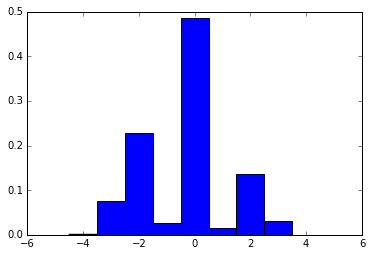

In [3]:
vals = df['NEXT']

print('mean: %f' % np.mean(vals))
print('median: %f' % np.median(vals))
plt.hist(vals, bins=np.arange(-4.5,5.5,1), normed=True)

As one might intuitively expect, the average next-possession value is negative, since typically the defending team successfully rebounds the ball following a miss. 

One natural question is how next-possession value changes with distance from the hoop.

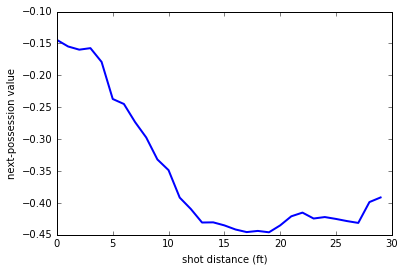

In [5]:
V = [np.mean(df[(df['SHOT_DISTANCE'] <= i+2) & (df['SHOT_DISTANCE'] >= i-2)]['NEXT']) for i in range(30)]
plt.plot(V, linewidth=2)
plt.xlabel('shot distance (ft)')
plt.ylabel('next-possession value')

Generally, as shot distance increases, next-possession value decreases. This is expected, since shorter shots make putbacks more likely, whereas longer shots allow for wild rebounds and fast breaks. Note that I cut off after 30 feet since the league-wide volume of shots from such distances is quite low (even in the Steph Curry era).

### Visualizing on the court

To clarify the spatial impact on next-possession value, we use our miss and location data to draw the "cold maps" promised earlier. Roughly speaking, the process is as follows:

1. separate the court into cells;
2. for each cell $\ell$, compute $v_\ell$ as well as the number of missed shots from $\ell$;
3. plot in "four dimensions": X location;  Y location; *color* to denote next-possession value; *size of cell* to denote miss volume.

I am very grateful to [Savvast Jortjoglou](http://savvastjortjoglou.com/nba-shot-sharts.html) and [Dan Vatterott](http://www.danvatterott.com/blog/2015/12/22/creating-nba-shot-charts/) for their extremely helpful guides to producing shot charts.

Tweaking the visualization to be as informative as possible is more of an art than a science. In particular:

* For color / next-possession value, one natural method is to use `matplotlib.colors.Normalize` to squeeze the min and max values of $v_\ell$ for $\ell \in \text{court}$ to fit between 0 and 1. Unfortunately, the interesting spatial homogeneity of $v_\ell$ does not appear all the way between the min and max values of $v_\ell$ (close to -3 and +3, respectively), but rather across a much smaller range (between -0.5 and -0.1).
* For size / miss volume, one natural method is to enforce the area of each cell to be proportional to the number of misses. Unfortunately, I find that the human eye isn't so good at gauging or differentiating size in any dimension greater than 1, so such a proportional rule leads to a very muddled plot. Instead, within `draw.shooting_plot`, I apply a [logistic](https://en.wikipedia.org/wiki/Logistic_function) transformation so that high volume (resp. low volume) locations have disproportionately large (resp. small) cells.

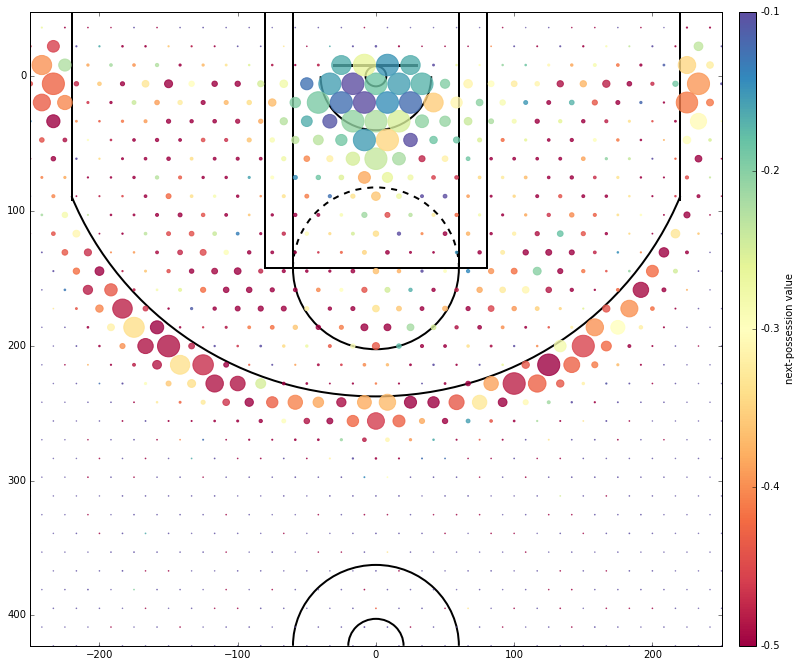

In [6]:
import draw
draw.shooting_plot(df)

For the most part, this cold map aligns with the insight from the plot of shot distance vs. next-possession value, with two major differences:

1. This cold map makes it clear where most shots are taken from. The bulk are either in the restricted area or beyond the 3-point line.
2. Compare the difference in color for corner 3s and long (straight-ahead) 3s. While neither type of shot is as safe as a layup at the rim, the corner 3 is distinctly safer than a long 3, likely due to: a) closer distance; and b) lower likelihood for punishing wild rebounds.

## Eventual TODO

One eventual goal is to use the much more fine-grained location data available thanks to the [SportVU](https://en.wikipedia.org/wiki/SportVU) motion-tracking system. In particular, I'd like to test my hypothesis that the spatial homogeneity of next-possession value is indeed due to different fast breaks and putback likelihoods. 

[Savvas Tjortjoglou](http://savvastjortjoglou.com/nba-play-by-play-movements.html) describes how to extract this data from the `locations_getmoments` endpoint. Unfortunately, [as of 16 Jan 2016](http://stats.nba.com/help/whatsnew/), this data is not availble on stats.nba.com, although there are several logs from the 2015-2016 season available at [github.com/neilmj](https://github.com/neilmj/BasketballData/tree/master/2016.NBA.Raw.SportVU.Game.Logs).